In [ ]:
!pip install --upgrade fastcore -q
!pip install --upgrade fastai -q

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 194kB 2.9MB/s 


In [ ]:
from fastai.vision.all import *

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/Colab Notebooks/Ambulance Parembulation"

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/Ambulance Parembulation


In [ ]:
df = pd.read_csv('Train.csv')
df.head()

,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


In [ ]:
kmeans = KMeans(n_clusters = 6)
cols = ['datetime', 'latitude', 'longitude']
X = df[cols]
kmeans.fit(X[X.columns[1:3]])
X['cluster_labels'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_
centroids = centers.copy()
centers = torch.from_numpy(centers)
centers

tensor([[-1.3043, 36.8421],
        [-1.2123, 36.9063],
        [-2.2888, 37.4565],
        [-1.0214, 37.0616],
        [-1.2349, 36.7251],
        [-1.4787, 37.0683]], dtype=torch.float64)

In [ ]:
ambulance_loc = centers.clone()
#ambulance_loc = torch.from_numpy(ambulance_loc)
ambulance_loc.requires_grad_()
data_points = tensor(df[['latitude', 'longitude']].values)
#define loss function 
def loss_fn(data_points, ambulance_loc):
  """For each crash we find the dist to the closest ambulance, and return the mean of these dists."""
  # Dists to first ambulance
  dists_split = data_points-ambulance_loc[0]
  dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
  min_dists = dists
  for i in range(1, 6):
    # Update dists so they represent the dist to the closest ambulance
    dists_split = data_points-ambulance_loc[i]
    dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
    min_dists = torch.min(min_dists, dists)
  
  return min_dists.mean()

In [ ]:
computed_loss = loss_fn(data_points, ambulance_loc)
computed_loss


tensor(0.0580, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
#the gradients can be computed as follows:
computed_loss.backward()
ambulance_loc.grad

tensor([[-0.0513,  0.0456],
        [-0.0016,  0.0150],
        [-0.0019, -0.0005],
        [ 0.0225,  0.0011],
        [ 0.0681, -0.0275],
        [ 0.0020,  0.0097]], dtype=torch.float64)

In [ ]:
#the loss can be reduced based on inferences from the gradients above as follows: 
ambulance_loc.grad = None # Reset gradients
lr=1e-2 # Pick LR
for i in range(1000):
  computed_loss = loss_fn(data_points, ambulance_loc) # Find loss
  if i % 100 == 0: print('Loss:', computed_loss.item()) # Print loss
  computed_loss.backward() # Calc grads
  ambulance_loc.data -= lr * ambulance_loc.grad.data # Update locs
  ambulance_loc.grad = None

Loss: 0.05797758009316684
Loss: 0.05556681581691337
Loss: 0.05528577696318002
Loss: 0.05513692491266719
Loss: 0.0550437883975753
Loss: 0.054985847715536246
Loss: 0.05494711212977203
Loss: 0.054914940647036184
Loss: 0.05488616642726878
Loss: 0.05482841493951343


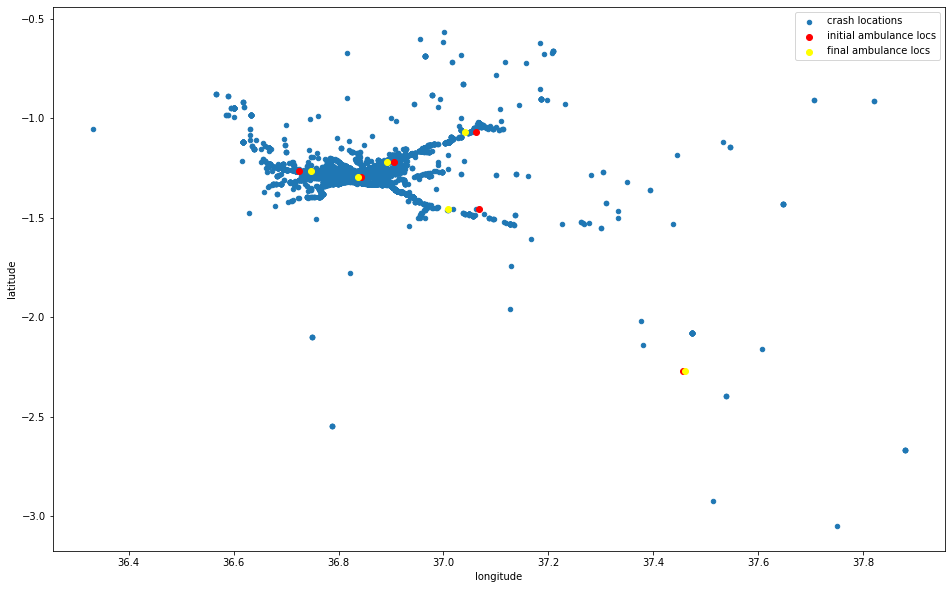

In [ ]:
# Plot crashes and ambulance locations
ax = df.plot(y='latitude', x='longitude', kind='scatter', figsize=(16, 10), label='crash locations')
ax.scatter(centers[:,1].detach().numpy(), ambulance_loc[:,0].detach().numpy(), c='red', label='initial ambulance locs')
ax.scatter(ambulance_loc[:,1].detach().numpy(), ambulance_loc[:,0].detach().numpy(), c='yellow', label='final ambulance locs')
ax.legend()

In [ ]:
ambulance_loc

tensor([[-1.2967, 36.8366],
        [-1.2190, 36.8924],
        [-2.2701, 37.4608],
        [-1.0694, 37.0406],
        [-1.2643, 36.7469],
        [-1.4538, 37.0086]], dtype=torch.float64, requires_grad=True)

In [ ]:
#Performing the SGD
# Split for validation
train_locations = data_points[:-1000]
val_locations = data_points[-1000:]

# Load crash locs from train into a dataloader
dl = DataLoader(train_locations, batch_size=1000, shuffle=True) 	

# Set up ambulance locations
ambulance_locations = centers
ambulance_locations.requires_grad_()

# Set vars
lr=3e-3
n_epochs = 70

# Store loss over time
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
   # Run through batches
  for crashes in dl:
    loss = loss_fn(crashes, ambulance_locations) # Find loss for this batch of crashes
    loss.backward() # Calc grads
    ambulance_locations.data -= lr * ambulance_locations.grad.data # Update locs
    ambulance_locations.grad = None # Reset gradients for next step
    train_losses.append(loss.item())
    val_losses.append(loss_fn(val_locations, ambulance_locations).item()) # Can remove as this lows things down

  # Print validation loss
  print('Val loss:', loss_fn(val_locations, ambulance_locations).item())

Val loss: 0.05429576124902936
Val loss: 0.05429576518219242
Val loss: 0.054295766051087595
Val loss: 0.05429576839285723
Val loss: 0.05429577481822798
Val loss: 0.054295781116010224
Val loss: 0.05429579088357626
Val loss: 0.05429579086998692
Val loss: 0.05429579298425582
Val loss: 0.054295796944217885
Val loss: 0.05429579670718582
Val loss: 0.05429580255381408
Val loss: 0.054295807409863686
Val loss: 0.05429580549612747
Val loss: 0.05429580971960466
Val loss: 0.05429581413289075
Val loss: 0.054295820142018274
Val loss: 0.05429582675951606
Val loss: 0.05429583404227369
Val loss: 0.054295837695370414
Val loss: 0.05429584099805818
Val loss: 0.054295842220663575
Val loss: 0.05429583927411657
Val loss: 0.05429583716656893
Val loss: 0.054295839905743146
Val loss: 0.05429584421179564
Val loss: 0.05429584320587952
Val loss: 0.05429585014740005
Val loss: 0.05429585586928036
Val loss: 0.0542958562970972
Val loss: 0.05429585758978098
Val loss: 0.05429585953199947
Val loss: 0.05429586336549224
Val

In [ ]:
ambulance_locations

tensor([[-1.3043, 36.8421],
        [-1.2123, 36.9063],
        [-2.2888, 37.4565],
        [-1.0214, 37.0616],
        [-1.2350, 36.7251],
        [-1.4787, 37.0683]], dtype=torch.float64, requires_grad=True)

In [ ]:
X.head()

,datetime,latitude,longitude,cluster_labels
0,2018-01-01 00:25:46,-1.188850,36.931382,1
1,2018-01-01 02:02:39,-0.662939,37.208730,3
2,2018-01-01 02:31:49,-0.662939,37.208730,3
3,2018-01-01 03:04:01,-1.288087,36.826583,0
4,2018-01-01 03:58:49,-1.188850,36.931382,1


In [ ]:
ambulance_locations
    
    
    
        
    

tensor([[-1.3043, 36.8421],
        [-1.2123, 36.9063],
        [-2.2888, 37.4565],
        [-1.0214, 37.0616],
        [-1.2350, 36.7251],
        [-1.4787, 37.0683]], dtype=torch.float64, requires_grad=True)

In [ ]:
X.cluster_labels.unique()

array([1, 3, 0, 5, 4, 2], dtype=int32)

In [ ]:
ambulance_locations = ambulance_locations.detach().numpy()
ambulance_locations

array([[-1.30427789, 36.84208636],
       [-1.21230322, 36.90634027],
       [-2.28881238, 37.4565474 ],
       [-1.0214284 , 37.06162756],
       [-1.23495829, 36.72513649],
       [-1.47865316, 37.06834359]])

In [ ]:
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})
sub['A0'+'_Latitude'] = ambulance_locations[0,0]
sub['A0'+'_Longitude'] = ambulance_locations[0][1]
sub['A1'+'_Latitude'] = ambulance_locations[1][0]
sub['A1'+'_Longitude'] = ambulance_locations[1][1]
sub['A2'+'_Latitude'] = ambulance_locations[2][0]
sub['A2'+'_Longitude'] = ambulance_locations[2][1]
sub['A3'+'_Latitude'] = ambulance_locations[3][0]
sub['A3'+'_Longitude'] = ambulance_locations[3][1]
sub['A4'+'_Latitude'] = ambulance_locations[4][0]
sub['A4'+'_Longitude'] = ambulance_locations[4][1]
sub['A5'+'_Latitude'] = ambulance_locations[5][0]
sub['A5'+'_Longitude'] = ambulance_locations[5][1]
'''for ambulance in range(1, 6):
    sub['A'+str(ambulance)+'_Latitude'] = ambulance_locationa[0][0]
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3
'''
sub.to_csv("submission.csv")
sub.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.304278,36.842086,-1.212303,36.90634,-2.288812,37.456547,-1.021428,37.061628,-1.234958,36.725136,-1.478653,37.068344
1,2019-01-01 03:00:00,-1.304278,36.842086,-1.212303,36.90634,-2.288812,37.456547,-1.021428,37.061628,-1.234958,36.725136,-1.478653,37.068344
2,2019-01-01 06:00:00,-1.304278,36.842086,-1.212303,36.90634,-2.288812,37.456547,-1.021428,37.061628,-1.234958,36.725136,-1.478653,37.068344
3,2019-01-01 09:00:00,-1.304278,36.842086,-1.212303,36.90634,-2.288812,37.456547,-1.021428,37.061628,-1.234958,36.725136,-1.478653,37.068344
4,2019-01-01 12:00:00,-1.304278,36.842086,-1.212303,36.90634,-2.288812,37.456547,-1.021428,37.061628,-1.234958,36.725136,-1.478653,37.068344


In [ ]:
sub.to_csv("sub5.csv")